# Tissue biopsy benchmark

In [1]:
# Imports

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
warnings.filterwarnings('ignore')

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *
from utils.table import *
from utils.metrics import *
from utils.venn import venn6, get_labels

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}
alpha_dict = dict(zip(config.tissuebenchmark.fractions, [1-i*0.3 for i in range(len(config.tissuebenchmark.fractions))]))

print(color_dict)
print(alpha_dict)

{'freebayes': 'tab:blue', 'mutect2': 'tab:orange', 'strelka2': 'tab:green', 'vardict': 'tab:red', 'varscan': 'tab:purple'}
{1: 1.0, 0.4: 0.7, 0.2: 0.4}


In [3]:
df_table = get_call_table_tissue(config)
print(df_table.shape)
df_table.head()

data/SMURF benchmark/snv-smurf-test20-v7-new5-maxdepth-2.tsv
icgc_cll_tumour
(9514, 47)
icgc_cll_T40_tumour
(2968, 47)
icgc_cll_T20_tumour
(3021, 47)
icgc_mbl_tumour
(17209, 47)
icgc_mbl_T40_tumour
(8566, 47)
icgc_mbl_T20_tumour
(10511, 47)
data/SMURF benchmark/indel-smurf-test20-v7-new5-maxdepth-2.tsv
icgc_cll_tumour
(8255, 47)
icgc_cll_T40_tumour
(2665, 47)
icgc_cll_T20_tumour
(3218, 47)
icgc_mbl_tumour
(5729, 47)
icgc_mbl_T40_tumour
(2927, 47)
icgc_mbl_T20_tumour
(3368, 47)
(77951, 15)


,CHROM_POS,sample,purity,mutation type,TRUTH,freebayes,mutect2,strelka2,vardict,varscan,freebayes_score,mutect2_score,strelka2_score,vardict_score,varscan_score
0,1_47492,icgc_cll_tumour,0.92,snv,False,False,False,False,False,True,NaN,NaN,NaN,NaN,14.0
1,1_52058,icgc_cll_tumour,0.92,snv,False,False,False,False,False,True,NaN,NaN,NaN,NaN,7.0
2,1_71992,icgc_cll_tumour,0.92,snv,False,True,False,False,False,False,0.900914,NaN,0.225538,0.99178,NaN
3,1_82115,icgc_cll_tumour,0.92,snv,False,False,False,False,False,True,NaN,NaN,NaN,0.95266,13.0
4,1_94824,icgc_cll_tumour,0.92,snv,False,False,False,False,True,False,0.865052,NaN,NaN,0.99969,NaN


# Precision - Recall curve

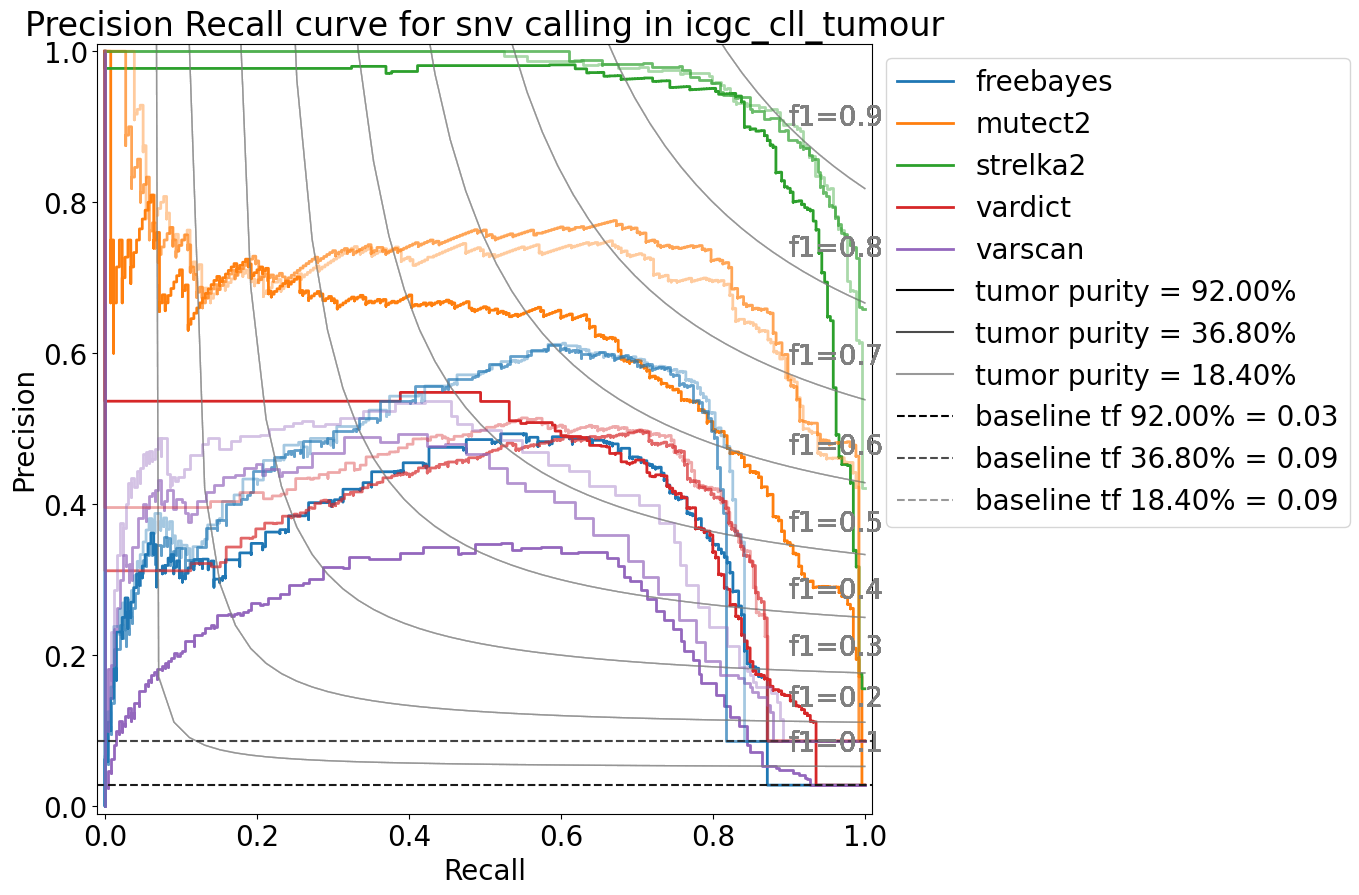

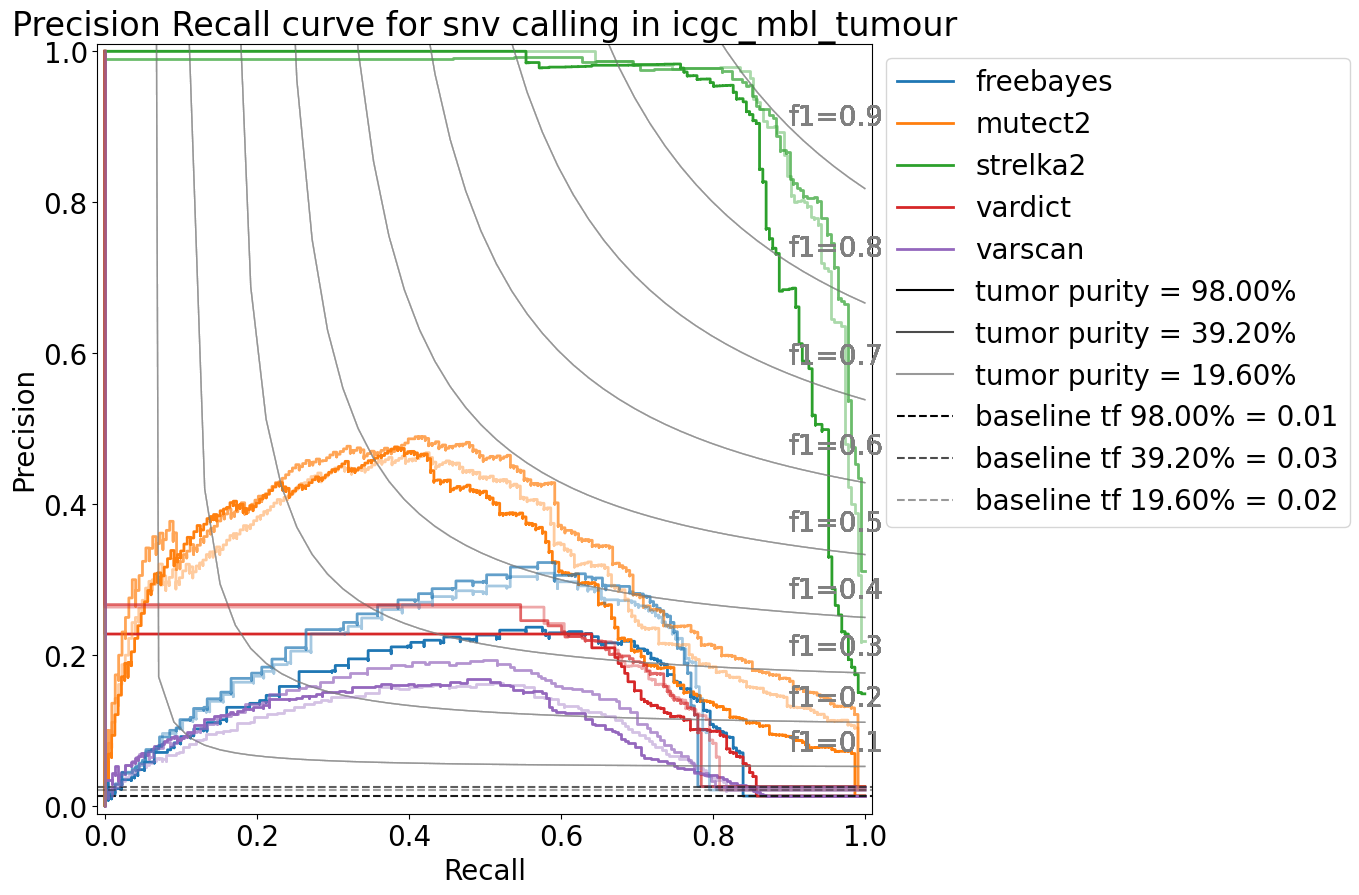

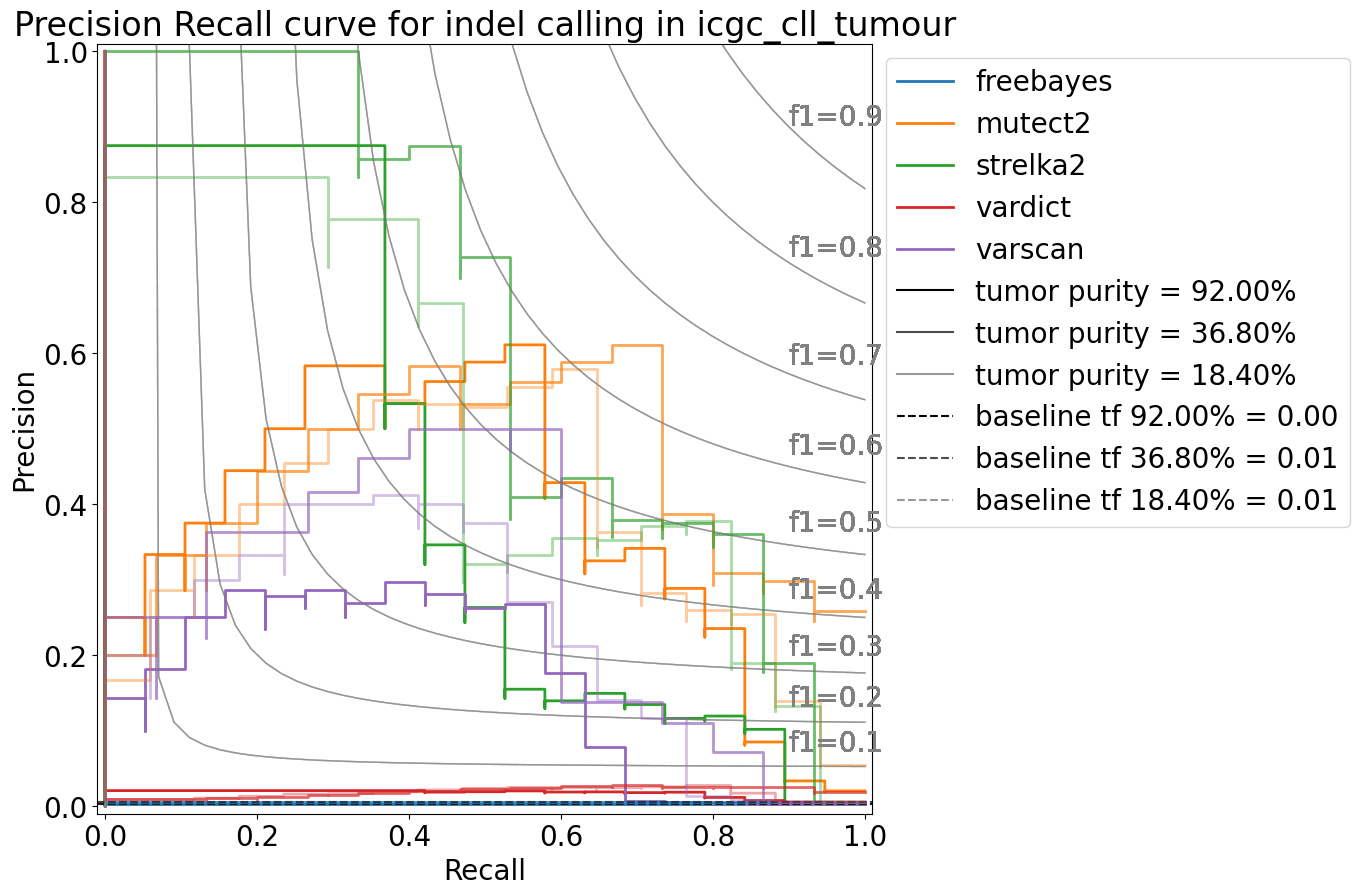

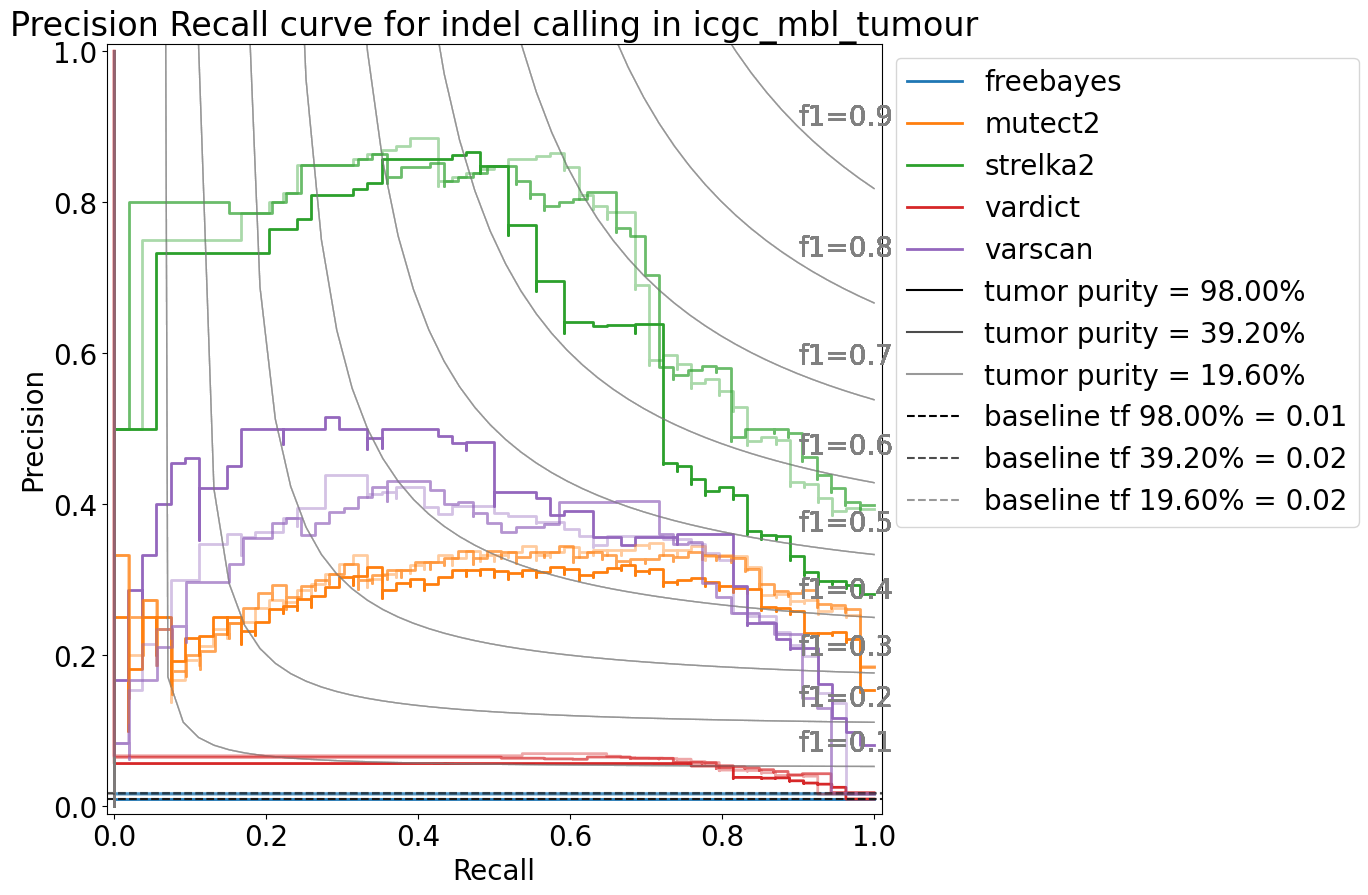

In [4]:
for muttype in config.muttype:
    for i, sample in enumerate(config.tissuebenchmark.samples):
        fig, ax = plt.subplots(figsize=(10,10))
        baseline_dict = {}
        for f in config.tissuebenchmark.fractions:
            for method in config.tissuebenchmark.methods:
                #print(muttype, sample, f, method)
                vcf_sample = df_table[(df_table['sample'] == sample) & (df_table['mutation type'] == muttype) & (df_table['purity'] == round(config.tissuebenchmark.purities[i]*f, 2))]
                df_sample_method = vcf_sample[[method+'_score', 'TRUTH']]
                df_sample_method[method + '_score'].fillna(0, inplace=True)
                precision, recall, thresholds = precision_recall_curve(df_sample_method['TRUTH'], df_sample_method[method + '_score'])
                f1 = f1_score(vcf_sample['TRUTH'], vcf_sample[method])
                estimator_name = method if f == 1 else ''
                plot_pr_curve(precision, recall, estimator_name=estimator_name, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[f], 'lw':2})
                baseline_dict[f] = len(vcf_sample['TRUTH'][vcf_sample['TRUTH']])/len(vcf_sample['TRUTH'])
            plt.axhline(y=baseline_dict[f], c='k', ls='--', alpha=alpha_dict[f])
        handles, labels = plt.gca().get_legend_handles_labels()
        list_lines = [Line2D([0], [0], color='black', alpha=alpha_dict[f], label='tumor purity = {:.2f}%'.format(round(100*config.tissuebenchmark.purities[i]*f, 2))) for f in config.tissuebenchmark.fractions]
        legend_list = handles + list_lines + [Line2D([0], [0], color='black', ls='--', alpha=alpha_dict[f], label="baseline tf {:.2f}% = {:.2f}".format(round(100*config.tissuebenchmark.purities[i]*f, 2), baseline_dict[f])) for f in config.tissuebenchmark.fractions]
        # Creating legend with color box
        plt.legend(bbox_to_anchor=(1, 1), loc="upper left", handles=legend_list)
        plt.title("Precision Recall curve for {} calling in {}".format(muttype, sample))
        #plt.loglog()
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        #plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_prcurve',  bbox_inches='tight')

#baseline_dict

# AUPRC plots


icgc_cll_tumour
icgc_mbl_tumour
icgc_cll_tumour
icgc_mbl_tumour


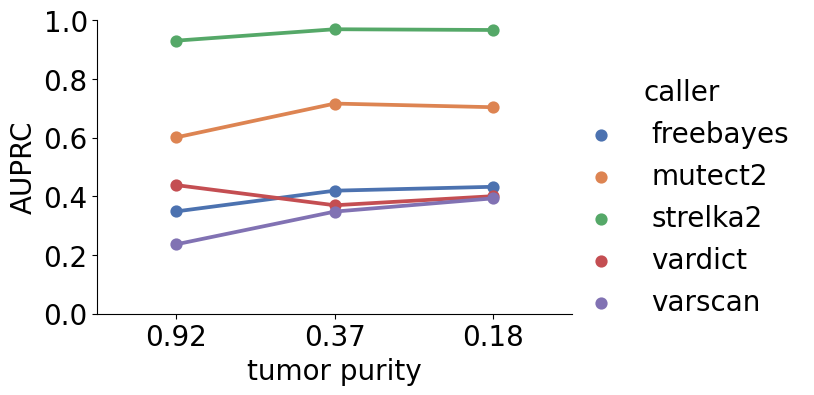

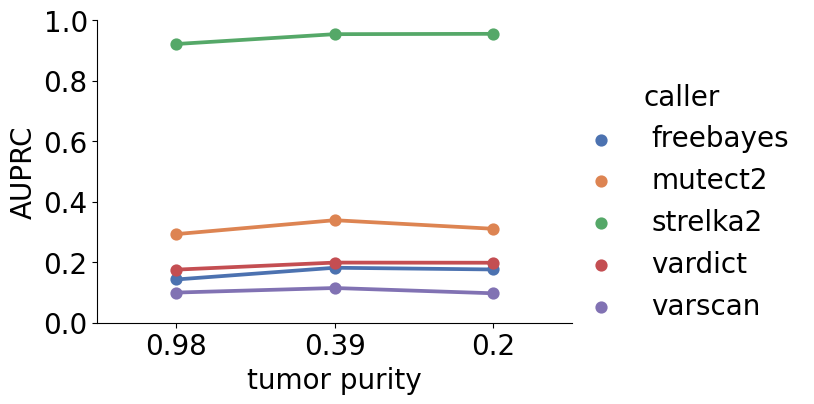

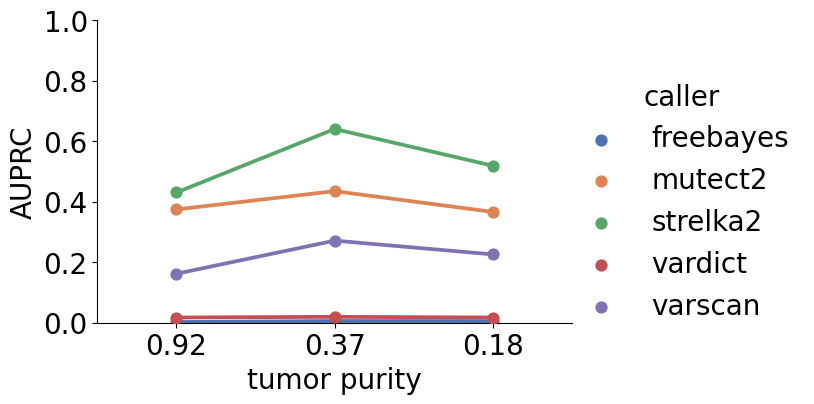

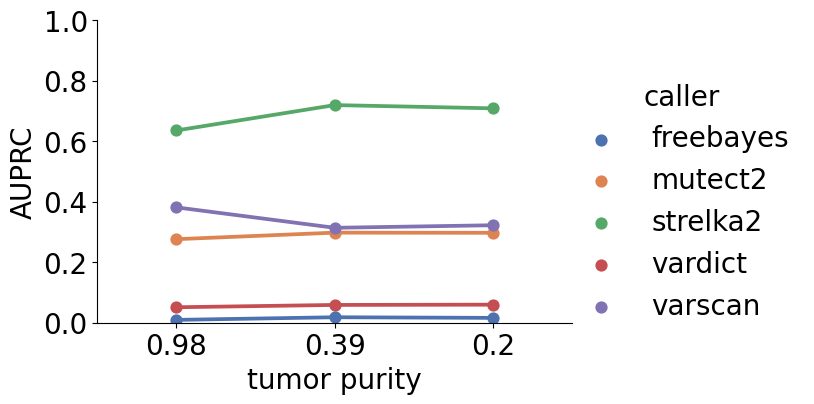

In [97]:
for muttype in ['SNV', 'INDEL']:
    if muttype == 'SNV':
        vcf_path = os.path.join(*config.tissuebenchmark, "snv-smurf-test20-v7-new5-maxdepth-2.tsv")
    elif muttype == 'INDEL':
        vcf_path = os.path.join(*config.tissuebenchmark, "indel-smurf-test20-v7-new5-maxdepth-2.tsv")
    vcf_samples = pd.read_csv(vcf_path, sep='\t')

    results_df = pd.DataFrame()
    aux_auprc = []
    aux_method = []
    aux_sample = []
    aux_tp = []
    #aux_auprcrelative = []

    for sample in samples:
        print(sample)
        sample_fractions = ['_'.join(sample.split('_')[:-1]) + f + '_'+ sample.split('_')[-1] for f in fraction_list]
        for i, s in enumerate(sample_fractions):
            # print(s)
            vcf_sample = vcf_samples[vcf_samples['Sample_Name'] == s]
            vcf_sample.reset_index(inplace=True)
            vcf_sample['CHROM_POS'] = vcf_sample['X.CHROM'].astype('str').str.cat(vcf_sample['POS'].astype('str'), sep="_")
            vcf_sample.set_index('CHROM_POS', inplace=True)
            vcf_sample['mutect2_score'] = np.exp(np.log(vcf_sample['m2_TLOD']))/(1+np.exp(np.log(vcf_sample['m2_TLOD']))) #vcf_sample['m2_TLOD']
            vcf_sample['freebayes_score'] = np.exp(np.log(vcf_sample['f_ODDS']))/(1+np.exp(np.log(vcf_sample['f_ODDS']))) #vcf_sample['f_ODDS']
            vcf_sample['strelka2_score'] = 1 - 10**(-vcf_sample['s2_SomaticEVS']/10) #vcf_sample['s2_SomaticEVS']
            vcf_sample['varscan_score'] = vcf_sample['vs_SSC']
            vcf_sample['vardict_score'] = 1 - vcf_sample['vd_SSF']

            for method in config.methods:
                df_sample_method = vcf_sample[[method+'_score', 'TRUTH']]
                df_sample_method[method + '_score'].fillna(0, inplace=True)
                # print(len(df_sample_method['TRUTH'][df_sample_method['TRUTH']])/len(df_sample_method['TRUTH']))
                auprc = average_precision_score(df_sample_method['TRUTH'], df_sample_method[method+'_score']) #- len(df_sample_method['TRUTH'][df_sample_method['TRUTH']])/len(df_sample_method['TRUTH'])
                aux_auprc.append(auprc)
                # aux_auprcrelative.append(auprc / baseline_dict[s])
                aux_method.append(method)
                aux_sample.append(sample)
                aux_tp.append(round(purity_dict[sample]*f_list[i], 2))

    results_df['AUPRC'] = aux_auprc
    #results_df['AUPRC - baseline'] = aux_auprcrelative
    results_df['tumor purity'] = aux_tp
    results_df['caller'] = aux_method
    results_df['sample'] = aux_sample

    #for si, sample in enumerate(samples):
    #    sns.catplot(x="tumor purity", y="AUPRC - baseline", hue="caller",
    #              capsize=.2, height=4, aspect=1.5, kind="point",
    #                order=sorted(results_df[results_df['sample'] == sample]['tumor purity'].unique(), reverse=True),
    #                    data=results_df[results_df['sample'] == sample])
    #    #plt.ylim([0, 1])
    #    plt.title('SNV AUPRC w.r.t. tumor purity in sample {}'.format(sample))


    for si, sample in enumerate(samples):
        sns.catplot(x="tumor purity", y="AUPRC", hue="caller",
                  capsize=.2, height=4, aspect=1.5, kind="point",
                    order=sorted(results_df[results_df['sample'] == sample]['tumor purity'].unique(), reverse=True),
                        data=results_df[results_df['sample'] == sample])
        #plt.axhline(y = baselineAUPRC, color = 'w', linestyle = '--', label='baseline AUPRC') 
        plt.ylim([0, 1])
        # plt.title(muttype+' AUPRC w.r.t. tumor purity in {}'.format(sample))

# Venn

(<Figure size 1920x1920 with 1 Axes>, <AxesSubplot:>)

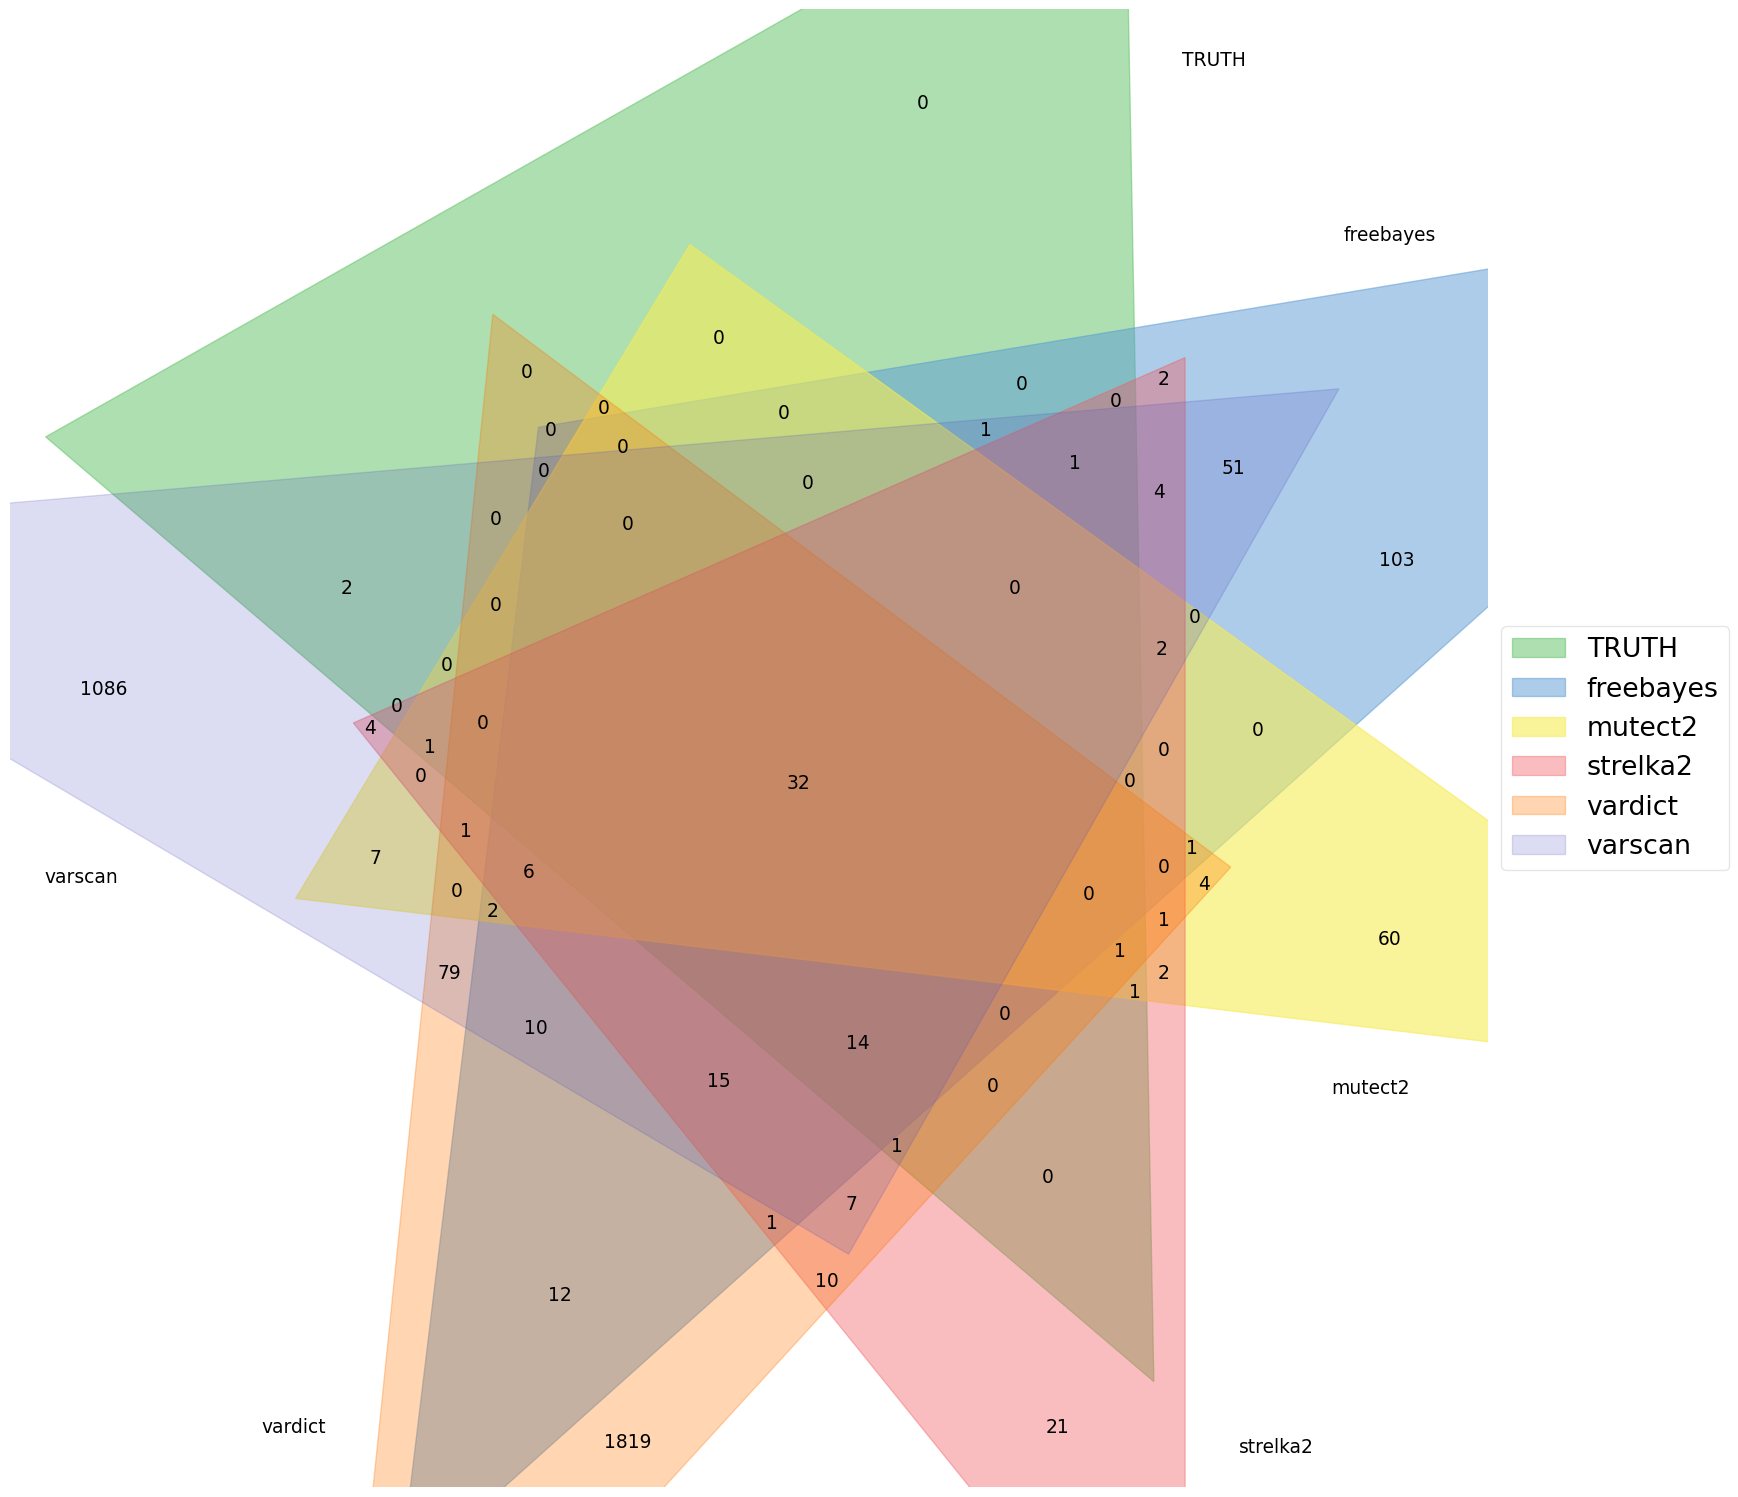

In [99]:
labels = get_labels([list(vcf_sample['TRUTH'][vcf_sample['TRUTH']].index)] + [list(vcf_sample['FILTER_'+m[0].upper()+m[1:]][vcf_sample['FILTER_'+m[0].upper()+m[1:]]].index) for m in config.methods], fill=["number"])
          
venn6(labels, names=['TRUTH'] + config.methods)

# True Positive and False Positive Mutations

In [98]:
for muttype in ['SNV', 'INDEL']:
    if muttype == 'SNV':
        vcf_path = os.path.join(*config.tissuebenchmark, "snv-smurf-test20-v7-new5-maxdepth-2.tsv")
    elif muttype == 'INDEL':
        vcf_path = os.path.join(*config.tissuebenchmark, "indel-smurf-test20-v7-new5-maxdepth-2.tsv")
    vcf_samples = pd.read_csv(vcf_path, sep='\t')
    for sample in samples:
        sample_fractions = ['_'.join(sample.split('_')[:-1]) + f + '_'+ sample.split('_')[-1] for f in fraction_list]
        print(sample)
        for i, s in enumerate(sample_fractions):
            print(i, s)
            vcf_sample = vcf_samples[vcf_samples['Sample_Name'] == s]
            vcf_sample.reset_index(inplace=True)
            vcf_sample['CHROM_POS'] = vcf_sample['X.CHROM'].astype('str').str.cat(vcf_sample['POS'].astype('str'), sep="_")
            vcf_sample.set_index('CHROM_POS', inplace=True)
            vcf_sample['mutect2_score'] = np.exp(np.log(vcf_sample['m2_TLOD']))/(1+np.exp(np.log(vcf_sample['m2_TLOD']))) #vcf_sample['m2_TLOD']
            vcf_sample['freebayes_score'] = np.exp(np.log(vcf_sample['f_ODDS']))/(1+np.exp(np.log(vcf_sample['f_ODDS']))) #vcf_sample['f_ODDS']
            vcf_sample['strelka2_score'] = 1 - 10**(-vcf_sample['s2_SomaticEVS']/10) #vcf_sample['s2_SomaticEVS']
            vcf_sample['varscan_score'] = vcf_sample['vs_SSC']
            vcf_sample['vardict_score'] = 1 - vcf_sample['vd_SSF']
            print('TRUE POSITIVE')
            print(vcf_sample[vcf_sample['TRUTH']].shape[1])
            print(vcf_sample[vcf_sample['TRUTH']][['FILTER_'+m[0].upper()+m[1:] for m in config.methods]].sum())
            print('FALSE POSITIVE')
            print(vcf_sample[~vcf_sample['TRUTH']].shape[1])
            print(vcf_sample[~vcf_sample['TRUTH']][['FILTER_'+m[0].upper()+m[1:] for m in config.methods]].sum())

icgc_cll_tumour
0 icgc_cll_tumour
TRUE POSITIVE
53
FILTER_Freebayes    231
FILTER_Mutect2      252
FILTER_Strelka2     254
FILTER_Vardict      243
FILTER_Varscan      245
dtype: int64
FALSE POSITIVE
53
FILTER_Freebayes     905
FILTER_Mutect2       316
FILTER_Strelka2      194
FILTER_Vardict       833
FILTER_Varscan      7474
dtype: int64
1 icgc_cll_T40_tumour
TRUE POSITIVE
53
FILTER_Freebayes    207
FILTER_Mutect2      227
FILTER_Strelka2     241
FILTER_Vardict      213
FILTER_Varscan      220
dtype: int64
FALSE POSITIVE
53
FILTER_Freebayes     198
FILTER_Mutect2       176
FILTER_Strelka2       45
FILTER_Vardict       441
FILTER_Varscan      2001
dtype: int64
2 icgc_cll_T20_tumour
TRUE POSITIVE
53
FILTER_Freebayes    215
FILTER_Mutect2      225
FILTER_Strelka2     248
FILTER_Vardict      217
FILTER_Varscan      227
dtype: int64
FALSE POSITIVE
53
FILTER_Freebayes     240
FILTER_Mutect2       167
FILTER_Strelka2       57
FILTER_Vardict       479
FILTER_Varscan      2000
dtype: int64
icgc

# False Positive Mutations

53


FILTER_Freebayes     209
FILTER_Mutect2        86
FILTER_Strelka2       76
FILTER_Vardict      1968
FILTER_Varscan      1275
dtype: int64

In [75]:
vcf_sample

,index,X.CHROM,POS,END_POS_REF,REF,ALT,REF_MFVdVs,ALT_MFVdVs,Sample_Name,FILTER_Mutect2,...,relcov,TRUTH,predict,FALSE.,TRUE.,mutect2_score,freebayes_score,strelka2_score,varscan_score,vardict_score
CHROM_POS,,,,,,,,,,,,,,,,,,,,,
1_714059,20887,1,714059,714059,C,CCGCCCTTGTGACGTCACGGAAGGCGCGCCCTTGCGACGTCACGGA...,NA/NA/C/NA/NA,NA/NA/CCGCCCTTGTGACGTCACGGAAGGCGCGCCCTTGCGACGT...,icgc_mbl_T20_tumour,False,...,3.186047,False,False,0.999885,0.000115,NaN,NaN,NaN,NaN,0.99996
1_749546,20891,1,749546,749548,CTG,C,NA/CTG/CTG/NA/CTG,NA/C/C/NA/C,icgc_mbl_T20_tumour,False,...,0.534884,False,False,0.999965,0.000035,NaN,NaN,0.563484,NaN,1.00000
1_763194,20895,1,763194,763198,TGCTC,G,NA/NA/TGCTC/NA/NA,NA/NA/G/NA/NA,icgc_mbl_T20_tumour,False,...,1.651163,False,False,0.999767,0.000233,NaN,NaN,NaN,NaN,0.93362
1_797135,20899,1,797135,797135,T,TGATA,T/NA/NA/NA/T,TGATA/NA/NA/NA/A,icgc_mbl_T20_tumour,True,...,1.488372,False,False,0.997638,0.002362,0.909008,NaN,0.129036,NaN,NaN
1_811690,20903,1,811690,811710,CCCCACACTCCCCCACACTCG,C,NA/NA/CCCCACACTCCCCCACACTCG/NA/NA,NA/NA/C/NA/NA,icgc_mbl_T20_tumour,False,...,1.604651,False,False,0.999930,0.000070,NaN,NaN,NaN,NaN,0.96438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y_28799149,37639,Y,28799149,28799154,CGTGGA,C,NA/NA/NA/CGTGGA/NA,NA/NA/NA/C/NA,icgc_mbl_T20_tumour,False,...,0.604651,False,False,0.999983,0.000017,NaN,NaN,NaN,11.0,NaN
Y_58859748,37642,Y,58859748,58859763,CGATTCCTTTCCATTG,C,NA/NA/NA/CGATTCCTTTCCATTG/NA,NA/NA/NA/C/NA,icgc_mbl_T20_tumour,False,...,2.965116,False,False,0.999970,0.000030,NaN,NaN,NaN,14.0,NaN
Y_58981330,37647,Y,58981330,58981340,CCACTCCACTT,C,NA/NA/NA/CCACTCCACTT/NA,NA/NA/NA/C/NA,icgc_mbl_T20_tumour,False,...,11.558140,False,False,0.999801,0.000199,NaN,NaN,NaN,39.0,NaN
